#  Exploratory Data Analysis

This notebook presents the exploratory data analysis of the study population.

* Part 1. Summary statistics of the original population
* Part 2. Summary statistics of the study population
* Part 3. Visualization of death time for in-hospital mortality

In [19]:
%pip install python-dotenv psycopg2-binary

from utils import connect_db
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
print("CWD:", os.getcwd())
print("Env file exists?", os.path.exists(".env"))


CWD: /Users/debduttaguharoy/Developer/Y2 - Master's Thesis/Usecases/Predicting-Death-Time-and-Mortality/Model/Code/Notebooks
Env file exists? True


---
## Part 1. Summary statistics of the original population

The original dataset in MIMIC-III database consists of 61,532 distinct ICU stays of 46,520 unique patients.

In [21]:
query = 'select * from icustays'
icustays = connect_db(query)
print('Number of distinct ICU stays: ', icustays.icustay_id.unique().shape[0])

query = 'select * from patients'
patients = connect_db(query)
print('Number of distinct patients: ', patients.subject_id.unique().shape[0])

/Users/debduttaguharoy/Developer/Y2 - Master's Thesis/Usecases/Predicting-Death-Time-and-Mortality/Model/Code/Notebooks/utils.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, con=con)


Number of distinct ICU stays:  61532
Number of distinct patients:  46520


---
## Part 2. Summary statistics of the study population

To form our study population, we have excluded ICU stays less than one hour to remove fuzziness in data due to unusual short stays and only consider adult patients with age between 16 and 89. The final study population covered 49,632 ICU stays of 36,343 patients. Please refer to `Code/Hive/mp_cohort.hql` for detailed construction of mp_cohort table.

In [22]:
query = """select * from mp_cohort"""
cohort = connect_db(query)
print(cohort.shape)
cohort.head()

(60186, 25)


,subject_id,hadm_id,icustay_id,dbsource,intime,outtime,age,gender,ethnicity,admission_type,...,hosp_los,hosp_deathtime_hours,deathtime_hours,deadthtime_check,exclusion_adult,exclusion_valid_data,exclusion_short_stay_4hr,exclusion_short_stay_1hr,exclusion_organ_donor,excluded
0,55973,152234,200001,metavision,2181-11-25 20:00:00,2181-11-28 20:00:00,61.0499,F,ASIAN - ASIAN INDIAN,EMERGENCY,...,15.901389,NaN,8764.0,NaT,0,0,0,0,0,0
1,27513,163557,200003,carevue,2199-08-02 20:00:00,2199-08-08 15:00:00,48.2940,M,WHITE,EMERGENCY,...,20.081944,NaN,1804.0,NaT,0,0,0,0,0,0
2,10950,189514,200006,carevue,2159-09-03 13:00:00,2159-09-04 17:00:00,54.0710,M,OTHER,EMERGENCY,...,2.304167,NaN,6083.0,NaT,0,0,0,0,0,0
3,20707,129310,200007,carevue,2109-02-17 12:00:00,2109-02-18 10:00:00,43.3439,M,WHITE,EMERGENCY,...,3.239583,NaN,NaN,NaT,0,0,0,0,0,0
4,29904,129607,200009,carevue,2189-11-30 19:00:00,2189-12-02 13:00:00,47.5548,F,WHITE,ELECTIVE,...,6.177083,NaN,NaN,NaT,0,0,0,0,0,0


In [23]:
# study population after filtering
study_cohort = cohort[cohort.excluded==0] 
print('Number of distinct ICU stays: ', study_cohort.icustay_id.unique().shape[0])
print('Number of distinct patients: ', study_cohort.subject_id.unique().shape[0])

Number of distinct ICU stays:  49632
Number of distinct patients:  36343


Once we we defined the study population, let us examine some of the features of the study population :
* age
* enthnicity
* admission type
* number of ICU stays
* in-hospital mortality

In [24]:
# age distribution
study_cohort[['subject_id','age']].groupby('subject_id').max().describe()

,age
count,36343.000000
mean,62.610401
std,16.931520
min,16.014000
25%,51.858800
50%,64.674900
75%,76.505400
max,88.998500


In [25]:
# gender distribution
gender_dist = study_cohort[['subject_id','gender']].groupby('subject_id').max().gender.value_counts()
print('Gender ratio (male:all): ', gender_dist[0]/gender_dist.sum())
print('Gender distribution:\n',gender_dist)

Gender ratio (male:all):  0.5778554329582037
Gender distribution:
 gender
M    21001
F    15342
Name: count, dtype: int64


/var/folders/qd/hxnw7jb56lb72yft16bm17c40000gn/T/ipykernel_48000/3350918701.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Gender ratio (male:all): ', gender_dist[0]/gender_dist.sum())


In [26]:
# ethnicity distribution
ethnicity_dist = study_cohort[['subject_id','ethnicity']].groupby('subject_id').max().ethnicity.value_counts()
#white = sum([ethnicity_dist[0], ethnicity_dist[11], ethnicity_dist[14], ethnicity_dist[17], ethnicity_dist[23]])
white = ethnicity_dist.iloc[:5].sum()
#print('White: ', white/ethnicity_dist.sum())
#print('Top 5 ethnicity:\n', ethnicity_dist[:5] )
print('White (top 5 approximation): ', white / ethnicity_dist.sum())
print('Top 5 ethnicity:\n', ethnicity_dist.iloc[:5])

White (top 5 approximation):  0.9206724816333269
Top 5 ethnicity:
 ethnicity
WHITE                     25577
UNKNOWN/NOT SPECIFIED      3497
BLACK/AFRICAN AMERICAN     2594
HISPANIC OR LATINO          939
OTHER                       853
Name: count, dtype: int64


In [27]:
# admission type
admissiontype_dist = study_cohort[['subject_id','admission_type']].groupby('subject_id').max().admission_type.value_counts()
print('Emergency: ', admissiontype_dist[0]/admissiontype_dist.sum())
print('All admission types:\n',admissiontype_dist)

Emergency:  0.8231296260627906
All admission types:
 admission_type
EMERGENCY    29915
ELECTIVE      5267
URGENT        1161
Name: count, dtype: int64


/var/folders/qd/hxnw7jb56lb72yft16bm17c40000gn/T/ipykernel_48000/441043326.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Emergency: ', admissiontype_dist[0]/admissiontype_dist.sum())


In [28]:
# num of ICU stays
study_cohort[['subject_id','icustay_num']].groupby('subject_id').max().describe()

,icustay_num
count,36343.000000
mean,1.365875
std,1.060728
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,41.000000


Note that `hospital_expire_flag=1` indicates in-hospital mortality. In Phase 1 of our model framework, we will predict this moratlity label by training a binary classifier on the study population.

In [29]:
# in-hospital mortality ratio
mortality_dist = study_cohort.hospital_expire_flag.value_counts()
print('In-hospital mortality ratio:' , mortality_dist[1]/mortality_dist.sum())
print('In-hospital mortality distribution:\n', mortality_dist)

In-hospital mortality ratio: 0.11617504835589942
In-hospital mortality distribution:
 hospital_expire_flag
0    43866
1     5766
Name: count, dtype: int64


---
## Part 3: Visualization of death time for in-hospital mortality
Note that `hosp_deathtime_hours` is the death time in hours since ICU admission for in-hospital mortality.  In Phase 2 of our model framework, we will predict the multiclass label of this variable by training a mulitclass classifier on the dead patients in our study population.

In [30]:
print('Num of in-hospital mortality: ', study_cohort[study_cohort.hospital_expire_flag==1].shape[0])

Num of in-hospital mortality:  5766


In [31]:
# filter out ICU stays with negative death time 
# which is likely an administrative error resulting in an incorrect ICU admission or incorrect death time
dead_patients = study_cohort[(study_cohort.hospital_expire_flag==1) & (study_cohort.hosp_deathtime_hours>=0)]
print('Num of in-hospital mortality (negative death time filtered out): ', dead_patients.shape[0])
# right after you load cohort:
#deaths = cohort[cohort.hospital_expire_flag==1]
#print(deaths.hosp_deathtime_hours.describe())
# maybe peek at the first few
#print(deaths.hosp_deathtime_hours)

Num of in-hospital mortality (negative death time filtered out):  5718


After filtering out the ICU stays with negative death time since ICU admission, 5,718 in-hospital mortality were resulted.

In [32]:
# death time distribution among dead patients (in hours)
dead_patients.hosp_deathtime_hours.describe()

count    5718.000000
mean      229.589367
std       312.152607
min         0.000000
25%        45.000000
50%       129.500000
75%       290.000000
max      4953.000000
Name: hosp_deathtime_hours, dtype: float64

The average death time since ICU admission is 9.57 days, maximum death time is 206.38 days and minimum death time is 0 day.

In [33]:
# death time distribution among dead patients (in days)
dead_patients.hosp_deathtime_hours.describe()/24

count    238.250000
mean       9.566224
std       13.006359
min        0.000000
25%        1.875000
50%        5.395833
75%       12.083333
max      206.375000
Name: hosp_deathtime_hours, dtype: float64

The box plot below shows the distribution of death time in hours since ICU admission for in-hospital mortality.

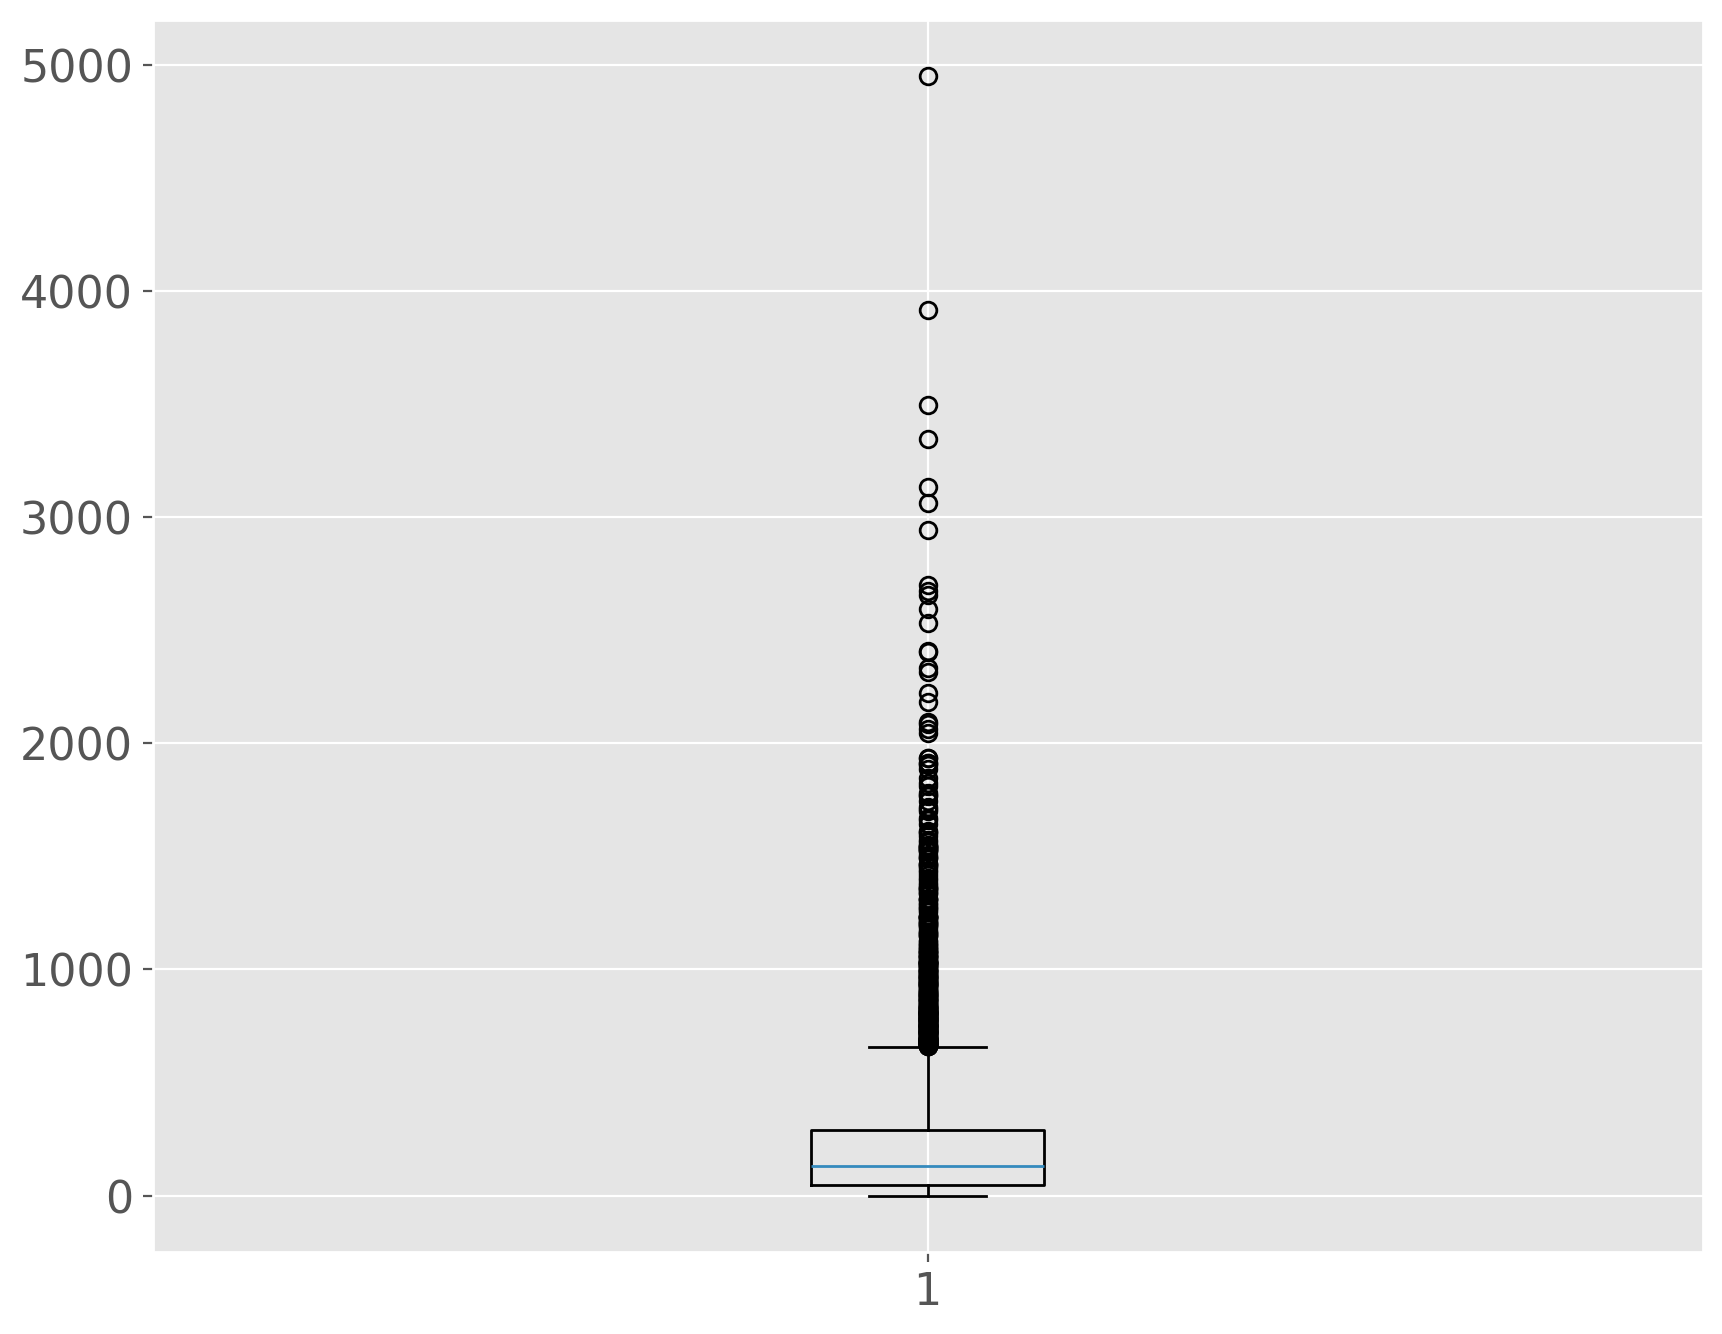

In [34]:
# Box plot of death time in hours since ICU admission
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure()
fig.set_size_inches(10,8)
plt.boxplot(dead_patients.hosp_deathtime_hours.tolist())
fig.savefig('../Images/figure1.png')
plt.show()

The histogram below shows a zoom-in picture (truncated to up 100 days) for the distribution of death time in days since ICU admission for in-hospital mortality.

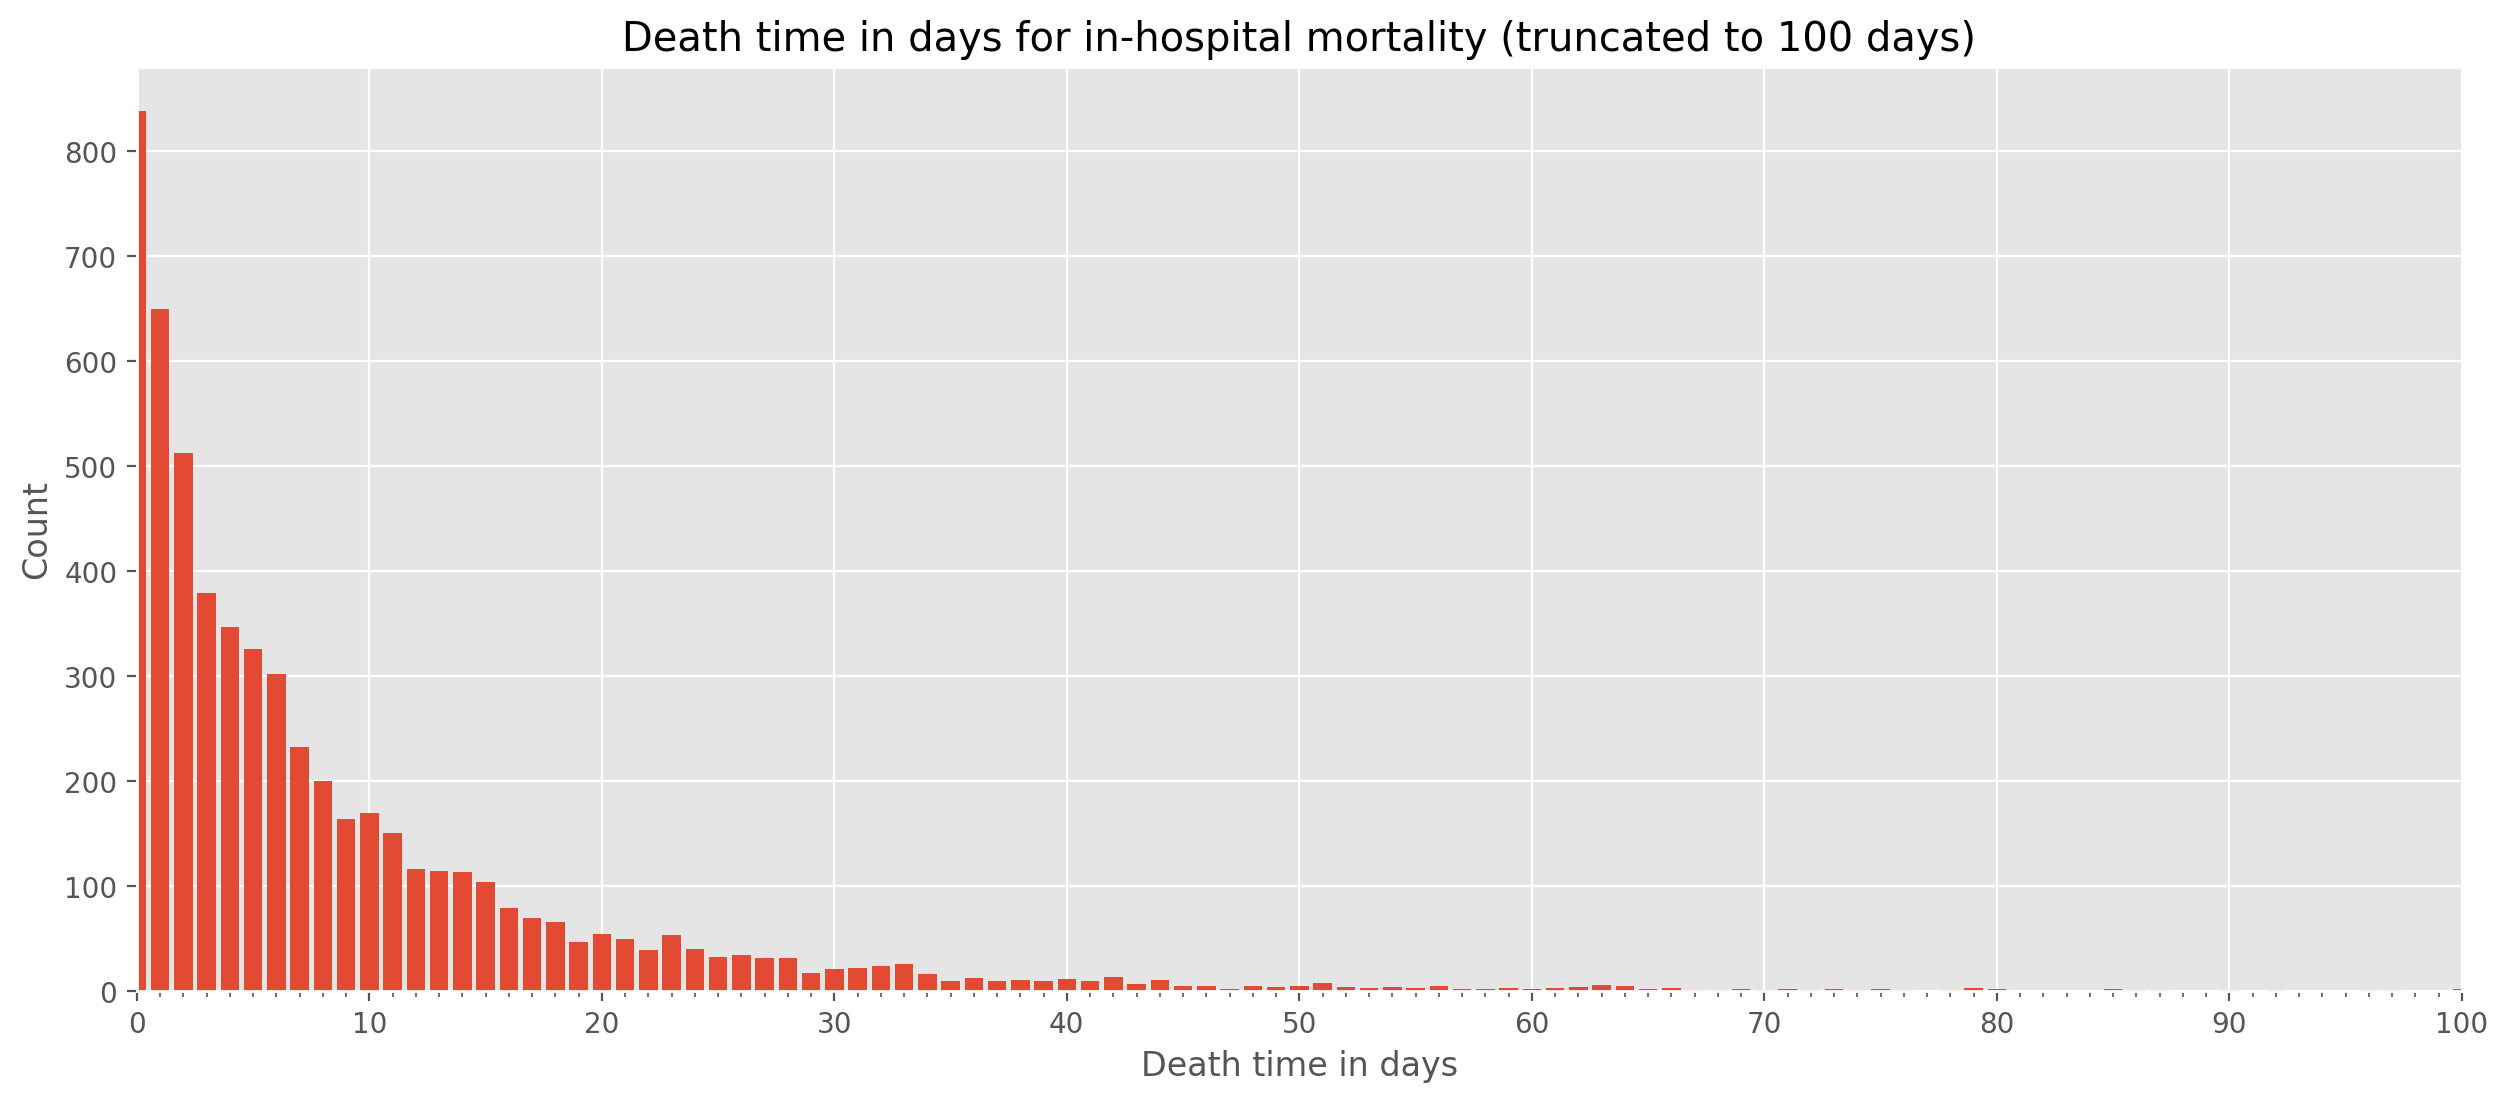

In [35]:
# Histogram of death time in days since ICU admission
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,6)
ax = plt.axes()
ax.set_xlim(0, 100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

data = (dead_patients[['icustay_id','hosp_deathtime_hours']]/24).astype(int)
data = data.groupby('hosp_deathtime_hours').size()
plt.bar(data.index, data, align='center')
plt.xlabel('Death time in days')
plt.ylabel('Count')
plt.title('Death time in days for in-hospital mortality (truncated to 100 days)')

plt.show()

Since we will predict the multiclass label of death time in hours since ICU admission in Phase 2, we want to look at the class label distribution as well. Specifically, we define the labels as follows:

* Class 0 : death time < 1 day
* Class 1 : 1 day <= death time < 1 week
* Class 2 : death time >= 1 week

In [36]:
# class label distribution of death time in hours
cutoff1 = 24
cutoff2 = 24*7
print('Cutoff hours: ', cutoff1, 'hours and', cutoff2, 'hours')
print('Class 0 size', len([x for x in dead_patients.hosp_deathtime_hours.tolist() if x < cutoff1]))
print('Class 1 size', len([x for x in dead_patients.hosp_deathtime_hours.tolist() if cutoff1 <= x < cutoff2]))
print('Class 2 size', len([x for x in dead_patients.hosp_deathtime_hours.tolist() if x >= cutoff2]))

Cutoff hours:  24 hours and 168 hours
Class 0 size 838
Class 1 size 2517
Class 2 size 2363
